# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'bandgap'
folder = 'MChX-bandgap'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset':            f'{target_folder}/dataset.pt',
    'train_dataset_std':  f'{target_folder}/train_dataset_std.pt',
    'val_dataset_std':    f'{target_folder}/val_dataset_std.pt',
    'test_dataset_std':   f'{target_folder}/test_dataset_std.pt',
    'r_dataset_std':      f'{target_folder}/ref_dataset_std.pt',
    'std_parameters':     f'{target_folder}/standardized_parameters.json',
    'dataset_parameters': f'{target_folder}/dataset_parameters.json',
    'uncertainty_data':   f'{target_folder}/uncertainty_data.json',
    'model':              f'{target_folder}/model.pt',
    'model_parameters':   f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      500
batch_size =    128
learning_rate = 0.0001
dropout =       0.2
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_parameters'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset_std, val_dataset_std, test_dataset_std, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset']):
        # Generate data
        cld.generate_dataset('datasets/MChX-bandgap',
                             targets=['bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dataset_parameters'])

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    #train_dataset_std, standardized_parameters = cld.standardize_dataset(train_dataset, transformation='inverse-quadratic')
    standardized_parameters = cld.load_json(files_names['std_parameters'])
    train_dataset_std = cld.standardize_dataset_from_keys(train_dataset, standardized_parameters)

    # Standardize test and validation datasets with train parameters
    val_dataset_std  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset_std = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset_std, val_dataset_std, test_dataset_std, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_parameters'])

# Defining target factor
target_factor = np.array(standardized_parameters['target_std']) / standardized_parameters['scale']
targe_mean    = standardized_parameters['target_mean']

MChX
	0.75_0.75_0.0
	0.75_0.25_1.0
	1.0_1.0_0.25
	0.0_0.25_0.75
	0.25_0.25_0.25
	0.5_0.0_1.0
	0.0_0.0_0.5
	0.75_0.0_0.5
	0.25_0.0_0.25
	0.0_0.5_1.0
	1.0_0.0_0.75
	0.75_0.5_0.0
	0.5_0.75_1.0
	0.25_0.5_0.75
	0.75_0.5_1.0
	0.0_1.0_1.0
	0.5_1.0_0.25
	1.0_1.0_0.5
	0.0_0.5_0.0
	0.0_1.0_0.25
	1.0_0.25_1.0
	0.5_0.5_1.0
	0.0_0.25_0.25
	0.75_0.5_0.25
	0.75_0.5_0.5
	1.0_0.5_0.25
	0.5_0.25_0.5
	0.0_0.75_0.75
	0.0_0.5_0.75
	1.0_1.0_0.0
	0.0_0.0_0.25
	0.25_0.75_1.0
	0.5_0.25_0.75
	0.25_0.0_0.75
	0.75_0.0_0.0
	0.0_0.25_0.5
	0.25_0.75_0.5
	0.0_0.5_0.5
	0.75_0.5_0.75
	0.5_0.0_0.25
	0.0_1.0_0.0
	0.75_1.0_1.0
	0.25_1.0_0.25
	1.0_0.0_0.0
	0.25_0.5_0.0
	0.75_0.75_0.25
	0.5_1.0_0.75
	0.5_0.5_0.5
	1.0_0.25_0.75
	0.0_0.5_0.25
	0.0_0.25_0.0
	0.5_0.75_0.75
	0.25_0.5_1.0
	0.75_1.0_0.0
	0.5_0.0_0.75
	0.5_1.0_0.0
	0.75_0.0_0.75
	0.25_1.0_1.0
	1.0_0.0_1.0
	0.75_1.0_0.5
	1.0_0.75_1.0
	1.0_0.75_0.0
	0.75_1.0_0.25
	0.25_0.5_0.5
	0.5_0.75_0.0
	0.25_0.75_0.25
	0.5_0.5_0.75
	0.0_1.0_0.75
	0.5_0.0_0.5
	0.0_0.25_1.0
	0.0_0

Define data loaders.

In [6]:
train_loader = DataLoader(train_dataset_std, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset_std,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset_std,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset_std[0].num_node_features

# Generate Graph Neural Network model

In [7]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [8]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model'])

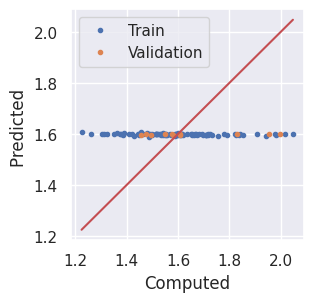

Epoch: 1, Train MAE: 0.1713, Val MAE: 0.1880
Epoch: 2, Train MAE: 0.1703, Val MAE: 0.1872
Epoch: 3, Train MAE: 0.1697, Val MAE: 0.1867
Epoch: 4, Train MAE: 0.1687, Val MAE: 0.1861
Epoch: 5, Train MAE: 0.1684, Val MAE: 0.1855
Epoch: 6, Train MAE: 0.1683, Val MAE: 0.1851
Epoch: 7, Train MAE: 0.1675, Val MAE: 0.1847
Epoch: 8, Train MAE: 0.1665, Val MAE: 0.1843
Epoch: 9, Train MAE: 0.1667, Val MAE: 0.1838
Epoch: 10, Train MAE: 0.1663, Val MAE: 0.1833


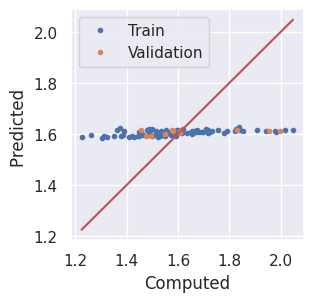

Epoch: 11, Train MAE: 0.1652, Val MAE: 0.1829
Epoch: 12, Train MAE: 0.1651, Val MAE: 0.1824
Epoch: 13, Train MAE: 0.1642, Val MAE: 0.1819
Epoch: 14, Train MAE: 0.1640, Val MAE: 0.1813
Epoch: 15, Train MAE: 0.1631, Val MAE: 0.1807
Epoch: 16, Train MAE: 0.1622, Val MAE: 0.1801
Epoch: 17, Train MAE: 0.1618, Val MAE: 0.1794
Epoch: 18, Train MAE: 0.1614, Val MAE: 0.1786
Epoch: 19, Train MAE: 0.1614, Val MAE: 0.1777
Epoch: 20, Train MAE: 0.1602, Val MAE: 0.1768


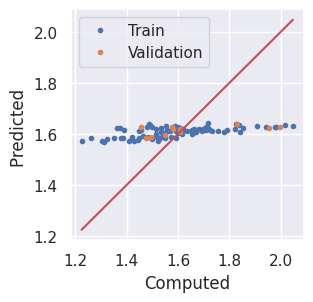

Epoch: 21, Train MAE: 0.1597, Val MAE: 0.1759
Epoch: 22, Train MAE: 0.1582, Val MAE: 0.1750
Epoch: 23, Train MAE: 0.1576, Val MAE: 0.1741
Epoch: 24, Train MAE: 0.1574, Val MAE: 0.1731
Epoch: 25, Train MAE: 0.1560, Val MAE: 0.1720
Epoch: 26, Train MAE: 0.1549, Val MAE: 0.1710
Epoch: 27, Train MAE: 0.1545, Val MAE: 0.1700
Epoch: 28, Train MAE: 0.1535, Val MAE: 0.1689
Epoch: 29, Train MAE: 0.1531, Val MAE: 0.1679
Epoch: 30, Train MAE: 0.1524, Val MAE: 0.1668


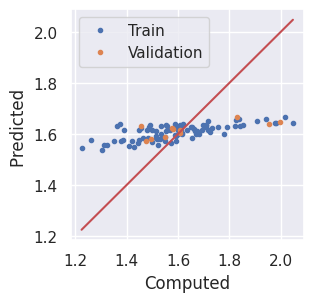

Epoch: 31, Train MAE: 0.1512, Val MAE: 0.1657
Epoch: 32, Train MAE: 0.1497, Val MAE: 0.1646
Epoch: 33, Train MAE: 0.1488, Val MAE: 0.1635
Epoch: 34, Train MAE: 0.1469, Val MAE: 0.1623
Epoch: 35, Train MAE: 0.1464, Val MAE: 0.1612
Epoch: 36, Train MAE: 0.1455, Val MAE: 0.1601
Epoch: 37, Train MAE: 0.1444, Val MAE: 0.1590
Epoch: 38, Train MAE: 0.1437, Val MAE: 0.1578
Epoch: 39, Train MAE: 0.1424, Val MAE: 0.1566
Epoch: 40, Train MAE: 0.1421, Val MAE: 0.1553


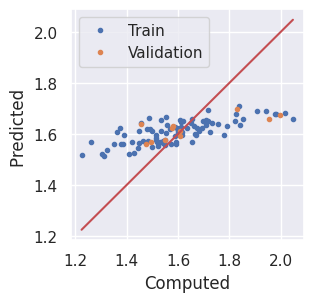

Epoch: 41, Train MAE: 0.1405, Val MAE: 0.1540
Epoch: 42, Train MAE: 0.1393, Val MAE: 0.1526
Epoch: 43, Train MAE: 0.1383, Val MAE: 0.1513
Epoch: 44, Train MAE: 0.1376, Val MAE: 0.1499
Epoch: 45, Train MAE: 0.1369, Val MAE: 0.1485
Epoch: 46, Train MAE: 0.1339, Val MAE: 0.1471
Epoch: 47, Train MAE: 0.1334, Val MAE: 0.1456
Epoch: 48, Train MAE: 0.1324, Val MAE: 0.1442
Epoch: 49, Train MAE: 0.1325, Val MAE: 0.1427
Epoch: 50, Train MAE: 0.1309, Val MAE: 0.1413


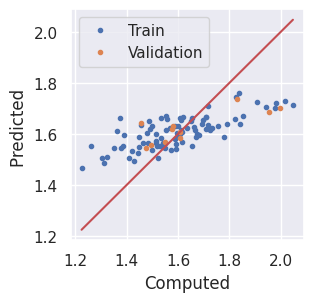

Epoch: 51, Train MAE: 0.1304, Val MAE: 0.1397
Epoch: 52, Train MAE: 0.1269, Val MAE: 0.1381
Epoch: 53, Train MAE: 0.1242, Val MAE: 0.1365
Epoch: 54, Train MAE: 0.1250, Val MAE: 0.1348
Epoch: 55, Train MAE: 0.1224, Val MAE: 0.1332
Epoch: 56, Train MAE: 0.1226, Val MAE: 0.1317
Epoch: 57, Train MAE: 0.1207, Val MAE: 0.1302
Epoch: 58, Train MAE: 0.1180, Val MAE: 0.1287
Epoch: 59, Train MAE: 0.1173, Val MAE: 0.1271
Epoch: 60, Train MAE: 0.1166, Val MAE: 0.1254


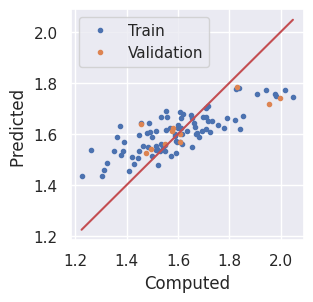

Epoch: 61, Train MAE: 0.1174, Val MAE: 0.1237
Epoch: 62, Train MAE: 0.1157, Val MAE: 0.1221
Epoch: 63, Train MAE: 0.1143, Val MAE: 0.1204
Epoch: 64, Train MAE: 0.1134, Val MAE: 0.1189
Epoch: 65, Train MAE: 0.1092, Val MAE: 0.1172
Epoch: 66, Train MAE: 0.1091, Val MAE: 0.1157
Epoch: 67, Train MAE: 0.1072, Val MAE: 0.1141
Epoch: 68, Train MAE: 0.1077, Val MAE: 0.1125
Epoch: 69, Train MAE: 0.1030, Val MAE: 0.1109
Epoch: 70, Train MAE: 0.1035, Val MAE: 0.1093


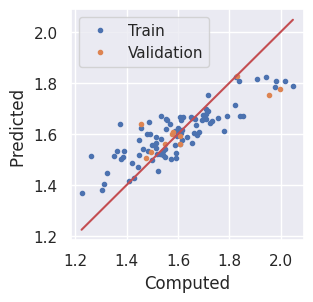

Epoch: 71, Train MAE: 0.1000, Val MAE: 0.1076
Epoch: 72, Train MAE: 0.1007, Val MAE: 0.1058
Epoch: 73, Train MAE: 0.1002, Val MAE: 0.1042
Epoch: 74, Train MAE: 0.0991, Val MAE: 0.1027
Epoch: 75, Train MAE: 0.0949, Val MAE: 0.1013
Epoch: 76, Train MAE: 0.0971, Val MAE: 0.1000
Epoch: 77, Train MAE: 0.0978, Val MAE: 0.0989
Epoch: 78, Train MAE: 0.0950, Val MAE: 0.0979
Epoch: 79, Train MAE: 0.0950, Val MAE: 0.0969
Epoch: 80, Train MAE: 0.0931, Val MAE: 0.0952


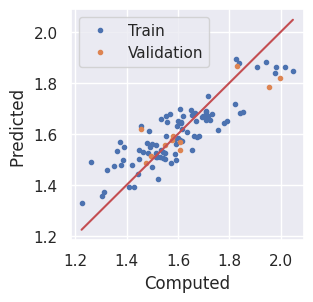

Epoch: 81, Train MAE: 0.0888, Val MAE: 0.0937
Epoch: 82, Train MAE: 0.0896, Val MAE: 0.0926
Epoch: 83, Train MAE: 0.0878, Val MAE: 0.0915
Epoch: 84, Train MAE: 0.0863, Val MAE: 0.0904
Epoch: 85, Train MAE: 0.0837, Val MAE: 0.0897
Epoch: 86, Train MAE: 0.0849, Val MAE: 0.0894
Epoch: 87, Train MAE: 0.0857, Val MAE: 0.0881
Epoch: 88, Train MAE: 0.0834, Val MAE: 0.0867
Epoch: 89, Train MAE: 0.0782, Val MAE: 0.0855
Epoch: 90, Train MAE: 0.0831, Val MAE: 0.0847


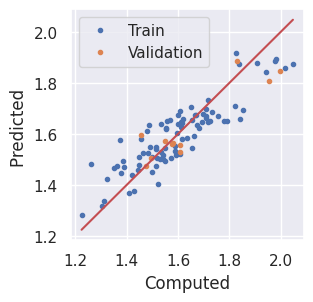

Epoch: 91, Train MAE: 0.0814, Val MAE: 0.0840
Epoch: 92, Train MAE: 0.0752, Val MAE: 0.0832
Epoch: 93, Train MAE: 0.0762, Val MAE: 0.0828
Epoch: 94, Train MAE: 0.0820, Val MAE: 0.0825
Epoch: 95, Train MAE: 0.0757, Val MAE: 0.0824
Epoch: 96, Train MAE: 0.0772, Val MAE: 0.0815
Epoch: 97, Train MAE: 0.0754, Val MAE: 0.0809
Epoch: 98, Train MAE: 0.0745, Val MAE: 0.0807
Epoch: 99, Train MAE: 0.0746, Val MAE: 0.0805
Epoch: 100, Train MAE: 0.0737, Val MAE: 0.0808


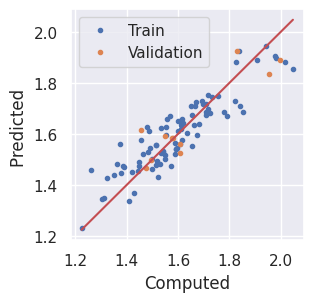

Epoch: 101, Train MAE: 0.0741, Val MAE: 0.0808
Epoch: 102, Train MAE: 0.0714, Val MAE: 0.0803
Epoch: 103, Train MAE: 0.0714, Val MAE: 0.0794
Epoch: 104, Train MAE: 0.0717, Val MAE: 0.0791
Epoch: 105, Train MAE: 0.0713, Val MAE: 0.0789
Epoch: 106, Train MAE: 0.0702, Val MAE: 0.0789
Epoch: 107, Train MAE: 0.0714, Val MAE: 0.0797
Epoch: 108, Train MAE: 0.0669, Val MAE: 0.0791
Epoch: 109, Train MAE: 0.0714, Val MAE: 0.0781
Epoch: 110, Train MAE: 0.0667, Val MAE: 0.0782


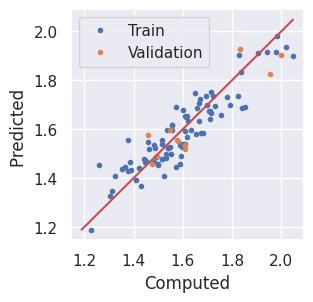

Epoch: 111, Train MAE: 0.0700, Val MAE: 0.0780
Epoch: 112, Train MAE: 0.0679, Val MAE: 0.0779
Epoch: 113, Train MAE: 0.0672, Val MAE: 0.0785
Epoch: 114, Train MAE: 0.0682, Val MAE: 0.0788
Epoch: 115, Train MAE: 0.0655, Val MAE: 0.0788
Epoch: 116, Train MAE: 0.0648, Val MAE: 0.0784
Epoch: 117, Train MAE: 0.0600, Val MAE: 0.0786
Epoch: 118, Train MAE: 0.0668, Val MAE: 0.0788
Epoch: 119, Train MAE: 0.0648, Val MAE: 0.0788
Epoch: 120, Train MAE: 0.0633, Val MAE: 0.0787


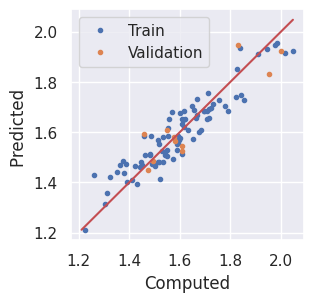

Epoch: 121, Train MAE: 0.0616, Val MAE: 0.0789
Epoch: 122, Train MAE: 0.0670, Val MAE: 0.0789
Epoch: 123, Train MAE: 0.0608, Val MAE: 0.0789
Epoch: 124, Train MAE: 0.0606, Val MAE: 0.0786
Epoch: 125, Train MAE: 0.0666, Val MAE: 0.0781
Epoch: 126, Train MAE: 0.0601, Val MAE: 0.0780
Epoch: 127, Train MAE: 0.0567, Val MAE: 0.0782
Epoch: 128, Train MAE: 0.0596, Val MAE: 0.0788
Epoch: 129, Train MAE: 0.0600, Val MAE: 0.0801
Epoch: 130, Train MAE: 0.0582, Val MAE: 0.0802


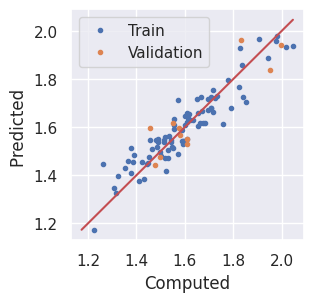

Epoch: 131, Train MAE: 0.0621, Val MAE: 0.0798
Epoch: 132, Train MAE: 0.0603, Val MAE: 0.0792
Epoch: 133, Train MAE: 0.0599, Val MAE: 0.0793
Epoch: 134, Train MAE: 0.0578, Val MAE: 0.0795
Epoch: 135, Train MAE: 0.0624, Val MAE: 0.0794
Epoch: 136, Train MAE: 0.0615, Val MAE: 0.0793
Epoch: 137, Train MAE: 0.0600, Val MAE: 0.0798
Epoch: 138, Train MAE: 0.0559, Val MAE: 0.0811
Epoch: 139, Train MAE: 0.0582, Val MAE: 0.0823
Epoch: 140, Train MAE: 0.0593, Val MAE: 0.0813


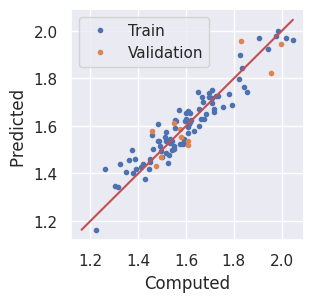

Epoch: 141, Train MAE: 0.0561, Val MAE: 0.0801
Epoch: 142, Train MAE: 0.0610, Val MAE: 0.0800
Epoch: 143, Train MAE: 0.0582, Val MAE: 0.0801
Epoch: 144, Train MAE: 0.0579, Val MAE: 0.0805
Epoch: 145, Train MAE: 0.0570, Val MAE: 0.0806
Epoch: 146, Train MAE: 0.0558, Val MAE: 0.0809
Epoch: 147, Train MAE: 0.0553, Val MAE: 0.0809
Epoch: 148, Train MAE: 0.0560, Val MAE: 0.0807
Epoch: 149, Train MAE: 0.0562, Val MAE: 0.0802
Epoch: 150, Train MAE: 0.0555, Val MAE: 0.0799


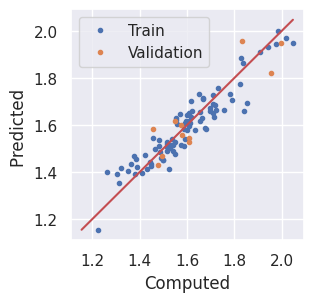

Epoch: 151, Train MAE: 0.0586, Val MAE: 0.0803
Epoch: 152, Train MAE: 0.0542, Val MAE: 0.0807
Epoch: 153, Train MAE: 0.0588, Val MAE: 0.0800
Epoch: 154, Train MAE: 0.0559, Val MAE: 0.0797
Epoch: 155, Train MAE: 0.0542, Val MAE: 0.0798
Epoch: 156, Train MAE: 0.0558, Val MAE: 0.0801
Epoch: 157, Train MAE: 0.0552, Val MAE: 0.0822
Epoch: 158, Train MAE: 0.0602, Val MAE: 0.0823
Epoch: 159, Train MAE: 0.0545, Val MAE: 0.0807
Epoch: 160, Train MAE: 0.0503, Val MAE: 0.0800


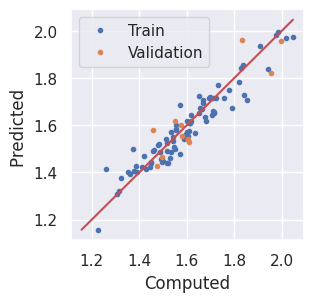

Epoch: 161, Train MAE: 0.0524, Val MAE: 0.0804
Epoch: 162, Train MAE: 0.0503, Val MAE: 0.0811
Epoch: 163, Train MAE: 0.0536, Val MAE: 0.0816
Epoch: 164, Train MAE: 0.0493, Val MAE: 0.0816
Epoch: 165, Train MAE: 0.0530, Val MAE: 0.0806
Epoch: 166, Train MAE: 0.0507, Val MAE: 0.0794
Epoch: 167, Train MAE: 0.0510, Val MAE: 0.0790
Epoch: 168, Train MAE: 0.0525, Val MAE: 0.0793
Epoch: 169, Train MAE: 0.0523, Val MAE: 0.0804
Epoch: 170, Train MAE: 0.0518, Val MAE: 0.0815


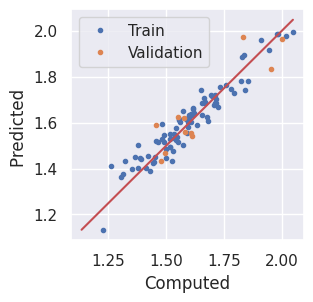

Epoch: 171, Train MAE: 0.0509, Val MAE: 0.0804
Epoch: 172, Train MAE: 0.0523, Val MAE: 0.0788
Epoch: 173, Train MAE: 0.0508, Val MAE: 0.0781
Epoch: 174, Train MAE: 0.0538, Val MAE: 0.0779
Epoch: 175, Train MAE: 0.0505, Val MAE: 0.0784
Epoch: 176, Train MAE: 0.0526, Val MAE: 0.0800
Epoch: 177, Train MAE: 0.0553, Val MAE: 0.0798
Epoch: 178, Train MAE: 0.0554, Val MAE: 0.0794
Epoch: 179, Train MAE: 0.0468, Val MAE: 0.0785
Epoch: 180, Train MAE: 0.0486, Val MAE: 0.0775


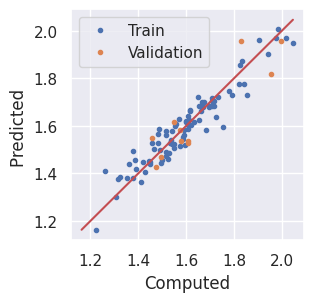

Epoch: 181, Train MAE: 0.0528, Val MAE: 0.0771
Epoch: 182, Train MAE: 0.0516, Val MAE: 0.0770
Epoch: 183, Train MAE: 0.0491, Val MAE: 0.0773
Epoch: 184, Train MAE: 0.0482, Val MAE: 0.0786
Epoch: 185, Train MAE: 0.0550, Val MAE: 0.0789
Epoch: 186, Train MAE: 0.0522, Val MAE: 0.0776
Epoch: 187, Train MAE: 0.0529, Val MAE: 0.0769
Epoch: 188, Train MAE: 0.0558, Val MAE: 0.0769
Epoch: 189, Train MAE: 0.0539, Val MAE: 0.0768
Epoch: 190, Train MAE: 0.0469, Val MAE: 0.0780


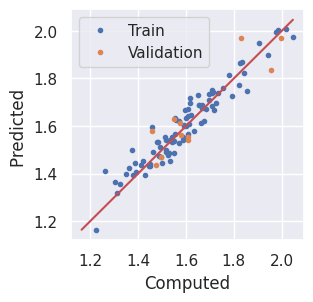

Epoch: 191, Train MAE: 0.0493, Val MAE: 0.0781
Epoch: 192, Train MAE: 0.0508, Val MAE: 0.0770
Epoch: 193, Train MAE: 0.0475, Val MAE: 0.0764
Epoch: 194, Train MAE: 0.0526, Val MAE: 0.0766
Epoch: 195, Train MAE: 0.0520, Val MAE: 0.0766
Epoch: 196, Train MAE: 0.0523, Val MAE: 0.0778
Epoch: 197, Train MAE: 0.0461, Val MAE: 0.0803
Epoch: 198, Train MAE: 0.0456, Val MAE: 0.0800
Epoch: 199, Train MAE: 0.0515, Val MAE: 0.0775
Epoch: 200, Train MAE: 0.0461, Val MAE: 0.0770


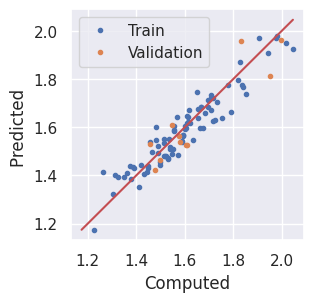

Epoch: 201, Train MAE: 0.0550, Val MAE: 0.0773
Epoch: 202, Train MAE: 0.0461, Val MAE: 0.0770
Epoch: 203, Train MAE: 0.0498, Val MAE: 0.0774
Epoch: 204, Train MAE: 0.0464, Val MAE: 0.0789
Epoch: 205, Train MAE: 0.0505, Val MAE: 0.0784
Epoch: 206, Train MAE: 0.0475, Val MAE: 0.0773
Epoch: 207, Train MAE: 0.0473, Val MAE: 0.0764
Epoch: 208, Train MAE: 0.0453, Val MAE: 0.0760
Epoch: 209, Train MAE: 0.0490, Val MAE: 0.0758
Epoch: 210, Train MAE: 0.0484, Val MAE: 0.0763


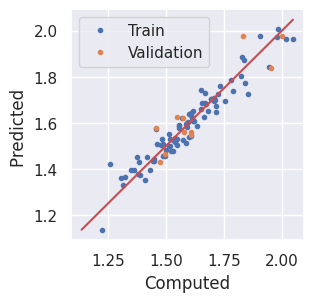

Epoch: 211, Train MAE: 0.0474, Val MAE: 0.0780
Epoch: 212, Train MAE: 0.0479, Val MAE: 0.0800
Epoch: 213, Train MAE: 0.0515, Val MAE: 0.0774
Epoch: 214, Train MAE: 0.0483, Val MAE: 0.0757
Epoch: 215, Train MAE: 0.0432, Val MAE: 0.0759
Epoch: 216, Train MAE: 0.0510, Val MAE: 0.0758
Epoch: 217, Train MAE: 0.0486, Val MAE: 0.0765
Epoch: 218, Train MAE: 0.0485, Val MAE: 0.0782
Epoch: 219, Train MAE: 0.0485, Val MAE: 0.0789
Epoch: 220, Train MAE: 0.0474, Val MAE: 0.0765


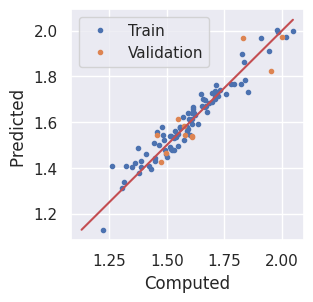

Epoch: 221, Train MAE: 0.0457, Val MAE: 0.0749
Epoch: 222, Train MAE: 0.0451, Val MAE: 0.0748
Epoch: 223, Train MAE: 0.0459, Val MAE: 0.0744
Epoch: 224, Train MAE: 0.0479, Val MAE: 0.0746
Epoch: 225, Train MAE: 0.0439, Val MAE: 0.0755
Epoch: 226, Train MAE: 0.0482, Val MAE: 0.0771
Epoch: 227, Train MAE: 0.0470, Val MAE: 0.0754
Epoch: 228, Train MAE: 0.0497, Val MAE: 0.0735
Epoch: 229, Train MAE: 0.0472, Val MAE: 0.0739
Epoch: 230, Train MAE: 0.0482, Val MAE: 0.0736


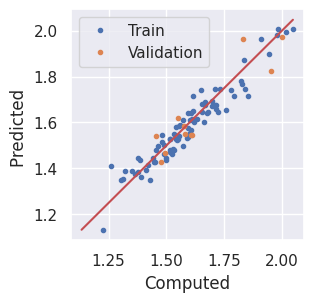

Epoch: 231, Train MAE: 0.0489, Val MAE: 0.0732
Epoch: 232, Train MAE: 0.0412, Val MAE: 0.0757
Epoch: 233, Train MAE: 0.0440, Val MAE: 0.0781
Epoch: 234, Train MAE: 0.0480, Val MAE: 0.0767
Epoch: 235, Train MAE: 0.0467, Val MAE: 0.0734
Epoch: 236, Train MAE: 0.0470, Val MAE: 0.0737
Epoch: 237, Train MAE: 0.0489, Val MAE: 0.0736
Epoch: 238, Train MAE: 0.0469, Val MAE: 0.0735
Epoch: 239, Train MAE: 0.0446, Val MAE: 0.0761
Epoch: 240, Train MAE: 0.0466, Val MAE: 0.0776


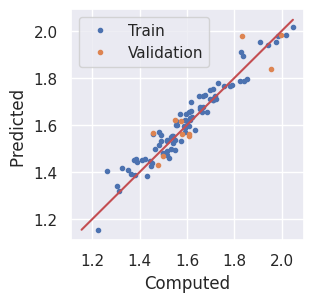

Epoch: 241, Train MAE: 0.0447, Val MAE: 0.0756
Epoch: 242, Train MAE: 0.0480, Val MAE: 0.0735
Epoch: 243, Train MAE: 0.0446, Val MAE: 0.0730
Epoch: 244, Train MAE: 0.0459, Val MAE: 0.0726
Epoch: 245, Train MAE: 0.0443, Val MAE: 0.0721
Epoch: 246, Train MAE: 0.0441, Val MAE: 0.0729
Epoch: 247, Train MAE: 0.0428, Val MAE: 0.0743
Epoch: 248, Train MAE: 0.0427, Val MAE: 0.0736
Epoch: 249, Train MAE: 0.0425, Val MAE: 0.0722
Epoch: 250, Train MAE: 0.0453, Val MAE: 0.0716


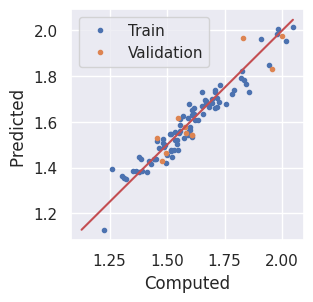

Epoch: 251, Train MAE: 0.0459, Val MAE: 0.0716
Epoch: 252, Train MAE: 0.0439, Val MAE: 0.0716
Epoch: 253, Train MAE: 0.0423, Val MAE: 0.0717
Epoch: 254, Train MAE: 0.0445, Val MAE: 0.0720
Epoch: 255, Train MAE: 0.0425, Val MAE: 0.0723
Epoch: 256, Train MAE: 0.0400, Val MAE: 0.0728
Epoch: 257, Train MAE: 0.0425, Val MAE: 0.0728
Epoch: 258, Train MAE: 0.0442, Val MAE: 0.0720
Epoch: 259, Train MAE: 0.0410, Val MAE: 0.0719
Epoch: 260, Train MAE: 0.0400, Val MAE: 0.0719


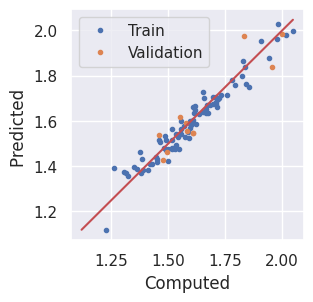

Epoch: 261, Train MAE: 0.0420, Val MAE: 0.0722
Epoch: 262, Train MAE: 0.0443, Val MAE: 0.0731
Epoch: 263, Train MAE: 0.0462, Val MAE: 0.0735
Epoch: 264, Train MAE: 0.0429, Val MAE: 0.0732
Epoch: 265, Train MAE: 0.0486, Val MAE: 0.0725
Epoch: 266, Train MAE: 0.0446, Val MAE: 0.0716
Epoch: 267, Train MAE: 0.0409, Val MAE: 0.0716
Epoch: 268, Train MAE: 0.0434, Val MAE: 0.0717
Epoch: 269, Train MAE: 0.0439, Val MAE: 0.0710
Epoch: 270, Train MAE: 0.0442, Val MAE: 0.0710


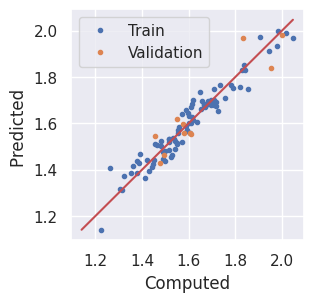

Epoch: 271, Train MAE: 0.0445, Val MAE: 0.0708
Epoch: 272, Train MAE: 0.0408, Val MAE: 0.0707
Epoch: 273, Train MAE: 0.0416, Val MAE: 0.0705
Epoch: 274, Train MAE: 0.0412, Val MAE: 0.0704
Epoch: 275, Train MAE: 0.0365, Val MAE: 0.0698
Epoch: 276, Train MAE: 0.0417, Val MAE: 0.0694
Epoch: 277, Train MAE: 0.0444, Val MAE: 0.0692
Epoch: 278, Train MAE: 0.0380, Val MAE: 0.0693
Epoch: 279, Train MAE: 0.0378, Val MAE: 0.0697
Epoch: 280, Train MAE: 0.0427, Val MAE: 0.0695


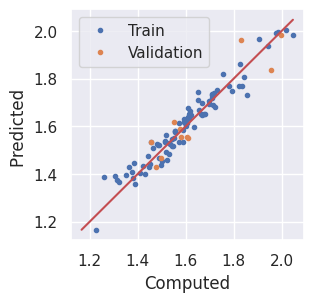

Epoch: 281, Train MAE: 0.0423, Val MAE: 0.0689
Epoch: 282, Train MAE: 0.0455, Val MAE: 0.0686
Epoch: 283, Train MAE: 0.0427, Val MAE: 0.0687
Epoch: 284, Train MAE: 0.0442, Val MAE: 0.0688
Epoch: 285, Train MAE: 0.0426, Val MAE: 0.0691
Epoch: 286, Train MAE: 0.0385, Val MAE: 0.0699
Epoch: 287, Train MAE: 0.0411, Val MAE: 0.0707
Epoch: 288, Train MAE: 0.0428, Val MAE: 0.0698
Epoch: 289, Train MAE: 0.0472, Val MAE: 0.0689
Epoch: 290, Train MAE: 0.0375, Val MAE: 0.0690


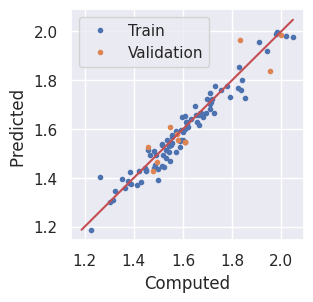

Epoch: 291, Train MAE: 0.0422, Val MAE: 0.0687
Epoch: 292, Train MAE: 0.0430, Val MAE: 0.0692
Epoch: 293, Train MAE: 0.0439, Val MAE: 0.0704
Epoch: 294, Train MAE: 0.0423, Val MAE: 0.0707
Epoch: 295, Train MAE: 0.0423, Val MAE: 0.0691
Epoch: 296, Train MAE: 0.0376, Val MAE: 0.0678
Epoch: 297, Train MAE: 0.0395, Val MAE: 0.0677
Epoch: 298, Train MAE: 0.0431, Val MAE: 0.0676
Epoch: 299, Train MAE: 0.0408, Val MAE: 0.0674
Epoch: 300, Train MAE: 0.0427, Val MAE: 0.0676


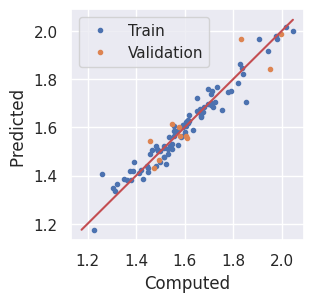

Epoch: 301, Train MAE: 0.0389, Val MAE: 0.0684
Epoch: 302, Train MAE: 0.0399, Val MAE: 0.0691
Epoch: 303, Train MAE: 0.0424, Val MAE: 0.0681
Epoch: 304, Train MAE: 0.0411, Val MAE: 0.0668
Epoch: 305, Train MAE: 0.0378, Val MAE: 0.0664
Epoch: 306, Train MAE: 0.0381, Val MAE: 0.0665
Epoch: 307, Train MAE: 0.0397, Val MAE: 0.0666
Epoch: 308, Train MAE: 0.0406, Val MAE: 0.0664
Epoch: 309, Train MAE: 0.0431, Val MAE: 0.0662
Epoch: 310, Train MAE: 0.0388, Val MAE: 0.0661


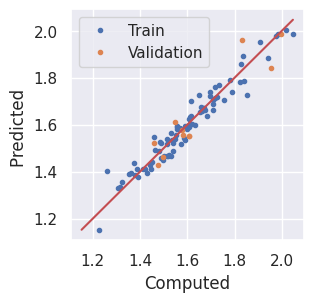

Epoch: 311, Train MAE: 0.0412, Val MAE: 0.0662
Epoch: 312, Train MAE: 0.0381, Val MAE: 0.0664
Epoch: 313, Train MAE: 0.0398, Val MAE: 0.0665
Epoch: 314, Train MAE: 0.0408, Val MAE: 0.0665
Epoch: 315, Train MAE: 0.0388, Val MAE: 0.0668
Epoch: 316, Train MAE: 0.0397, Val MAE: 0.0673
Epoch: 317, Train MAE: 0.0405, Val MAE: 0.0670
Epoch: 318, Train MAE: 0.0367, Val MAE: 0.0668
Epoch: 319, Train MAE: 0.0403, Val MAE: 0.0669
Epoch: 320, Train MAE: 0.0391, Val MAE: 0.0667


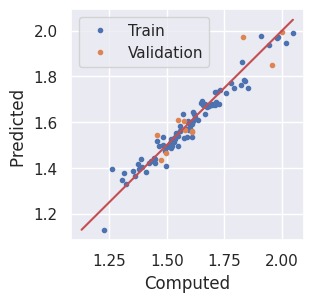

Epoch: 321, Train MAE: 0.0385, Val MAE: 0.0677
Epoch: 322, Train MAE: 0.0407, Val MAE: 0.0689
Epoch: 323, Train MAE: 0.0414, Val MAE: 0.0684
Epoch: 324, Train MAE: 0.0387, Val MAE: 0.0666
Epoch: 325, Train MAE: 0.0379, Val MAE: 0.0658
Epoch: 326, Train MAE: 0.0370, Val MAE: 0.0659
Epoch: 327, Train MAE: 0.0405, Val MAE: 0.0653
Epoch: 328, Train MAE: 0.0409, Val MAE: 0.0662
Epoch: 329, Train MAE: 0.0388, Val MAE: 0.0680
Epoch: 330, Train MAE: 0.0376, Val MAE: 0.0684


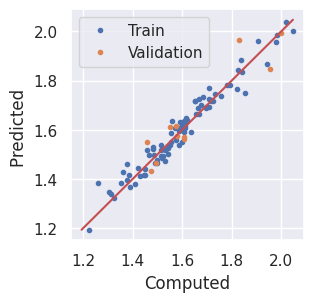

Epoch: 331, Train MAE: 0.0378, Val MAE: 0.0677
Epoch: 332, Train MAE: 0.0394, Val MAE: 0.0659
Epoch: 333, Train MAE: 0.0385, Val MAE: 0.0655
Epoch: 334, Train MAE: 0.0396, Val MAE: 0.0655
Epoch: 335, Train MAE: 0.0357, Val MAE: 0.0656
Epoch: 336, Train MAE: 0.0425, Val MAE: 0.0660
Epoch: 337, Train MAE: 0.0415, Val MAE: 0.0670
Epoch: 338, Train MAE: 0.0405, Val MAE: 0.0665
Epoch: 339, Train MAE: 0.0385, Val MAE: 0.0659
Epoch: 340, Train MAE: 0.0377, Val MAE: 0.0650


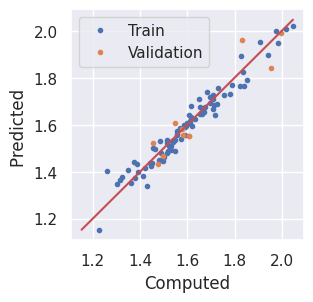

Epoch: 341, Train MAE: 0.0382, Val MAE: 0.0646
Epoch: 342, Train MAE: 0.0382, Val MAE: 0.0643
Epoch: 343, Train MAE: 0.0376, Val MAE: 0.0642
Epoch: 344, Train MAE: 0.0354, Val MAE: 0.0643
Epoch: 345, Train MAE: 0.0354, Val MAE: 0.0644
Epoch: 346, Train MAE: 0.0399, Val MAE: 0.0643
Epoch: 347, Train MAE: 0.0382, Val MAE: 0.0638
Epoch: 348, Train MAE: 0.0370, Val MAE: 0.0636
Epoch: 349, Train MAE: 0.0382, Val MAE: 0.0634
Epoch: 350, Train MAE: 0.0398, Val MAE: 0.0634


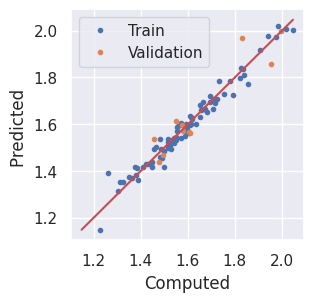

Epoch: 351, Train MAE: 0.0317, Val MAE: 0.0643
Epoch: 352, Train MAE: 0.0389, Val MAE: 0.0639
Epoch: 353, Train MAE: 0.0378, Val MAE: 0.0633
Epoch: 354, Train MAE: 0.0393, Val MAE: 0.0631
Epoch: 355, Train MAE: 0.0373, Val MAE: 0.0631
Epoch: 356, Train MAE: 0.0362, Val MAE: 0.0632
Epoch: 357, Train MAE: 0.0363, Val MAE: 0.0632
Epoch: 358, Train MAE: 0.0381, Val MAE: 0.0636
Epoch: 359, Train MAE: 0.0380, Val MAE: 0.0639
Epoch: 360, Train MAE: 0.0380, Val MAE: 0.0639


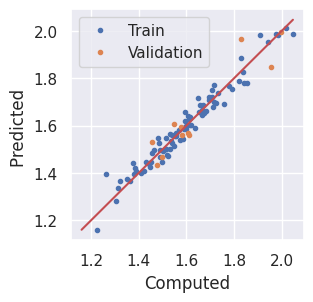

Epoch: 361, Train MAE: 0.0355, Val MAE: 0.0638
Epoch: 362, Train MAE: 0.0342, Val MAE: 0.0634
Epoch: 363, Train MAE: 0.0421, Val MAE: 0.0627
Epoch: 364, Train MAE: 0.0350, Val MAE: 0.0623
Epoch: 365, Train MAE: 0.0392, Val MAE: 0.0623
Epoch: 366, Train MAE: 0.0367, Val MAE: 0.0625
Epoch: 367, Train MAE: 0.0410, Val MAE: 0.0627
Epoch: 368, Train MAE: 0.0353, Val MAE: 0.0627
Epoch: 369, Train MAE: 0.0370, Val MAE: 0.0620
Epoch: 370, Train MAE: 0.0377, Val MAE: 0.0618


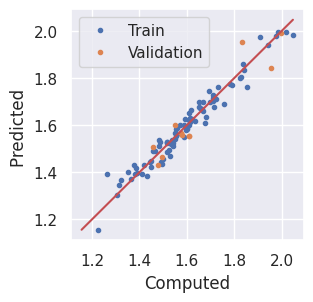

Epoch: 371, Train MAE: 0.0351, Val MAE: 0.0620
Epoch: 372, Train MAE: 0.0388, Val MAE: 0.0621
Epoch: 373, Train MAE: 0.0319, Val MAE: 0.0624
Epoch: 374, Train MAE: 0.0357, Val MAE: 0.0632
Epoch: 375, Train MAE: 0.0365, Val MAE: 0.0633
Epoch: 376, Train MAE: 0.0353, Val MAE: 0.0627
Epoch: 377, Train MAE: 0.0382, Val MAE: 0.0627
Epoch: 378, Train MAE: 0.0331, Val MAE: 0.0626
Epoch: 379, Train MAE: 0.0347, Val MAE: 0.0627
Epoch: 380, Train MAE: 0.0333, Val MAE: 0.0632


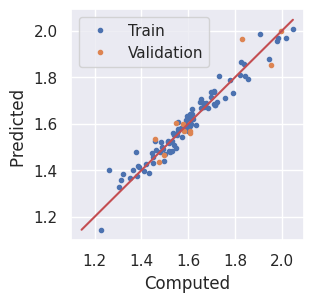

Epoch: 381, Train MAE: 0.0388, Val MAE: 0.0633
Epoch: 382, Train MAE: 0.0362, Val MAE: 0.0627
Epoch: 383, Train MAE: 0.0383, Val MAE: 0.0621
Epoch: 384, Train MAE: 0.0369, Val MAE: 0.0622
Epoch: 385, Train MAE: 0.0348, Val MAE: 0.0624
Epoch: 386, Train MAE: 0.0363, Val MAE: 0.0624
Epoch: 387, Train MAE: 0.0355, Val MAE: 0.0617
Epoch: 388, Train MAE: 0.0349, Val MAE: 0.0612
Epoch: 389, Train MAE: 0.0346, Val MAE: 0.0609
Epoch: 390, Train MAE: 0.0351, Val MAE: 0.0609


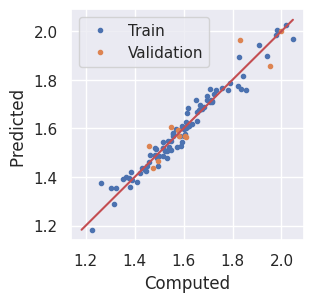

Epoch: 391, Train MAE: 0.0343, Val MAE: 0.0615
Epoch: 392, Train MAE: 0.0376, Val MAE: 0.0614
Epoch: 393, Train MAE: 0.0373, Val MAE: 0.0611
Epoch: 394, Train MAE: 0.0355, Val MAE: 0.0606
Epoch: 395, Train MAE: 0.0368, Val MAE: 0.0605
Epoch: 396, Train MAE: 0.0339, Val MAE: 0.0604
Epoch: 397, Train MAE: 0.0373, Val MAE: 0.0602
Epoch: 398, Train MAE: 0.0385, Val MAE: 0.0604
Epoch: 399, Train MAE: 0.0367, Val MAE: 0.0605
Epoch: 400, Train MAE: 0.0381, Val MAE: 0.0600


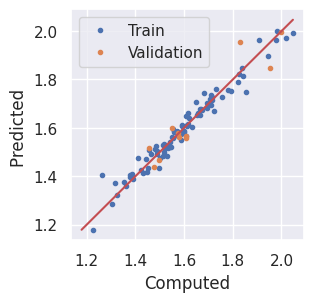

Epoch: 401, Train MAE: 0.0341, Val MAE: 0.0598
Epoch: 402, Train MAE: 0.0336, Val MAE: 0.0598
Epoch: 403, Train MAE: 0.0353, Val MAE: 0.0598
Epoch: 404, Train MAE: 0.0338, Val MAE: 0.0601
Epoch: 405, Train MAE: 0.0326, Val MAE: 0.0607
Epoch: 406, Train MAE: 0.0345, Val MAE: 0.0613
Epoch: 407, Train MAE: 0.0348, Val MAE: 0.0609
Epoch: 408, Train MAE: 0.0341, Val MAE: 0.0606
Epoch: 409, Train MAE: 0.0389, Val MAE: 0.0603
Epoch: 410, Train MAE: 0.0337, Val MAE: 0.0600


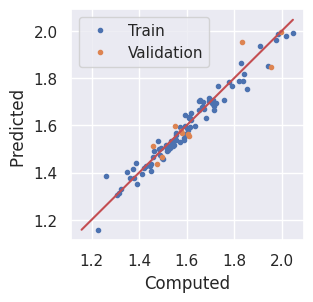

Epoch: 411, Train MAE: 0.0353, Val MAE: 0.0598
Epoch: 412, Train MAE: 0.0344, Val MAE: 0.0606
Epoch: 413, Train MAE: 0.0344, Val MAE: 0.0618
Epoch: 414, Train MAE: 0.0351, Val MAE: 0.0613
Epoch: 415, Train MAE: 0.0365, Val MAE: 0.0595
Epoch: 416, Train MAE: 0.0335, Val MAE: 0.0597
Epoch: 417, Train MAE: 0.0351, Val MAE: 0.0596
Epoch: 418, Train MAE: 0.0377, Val MAE: 0.0598
Epoch: 419, Train MAE: 0.0336, Val MAE: 0.0612
Epoch: 420, Train MAE: 0.0355, Val MAE: 0.0612


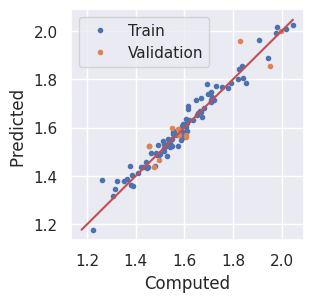

Epoch: 421, Train MAE: 0.0338, Val MAE: 0.0606
Epoch: 422, Train MAE: 0.0375, Val MAE: 0.0597
Epoch: 423, Train MAE: 0.0315, Val MAE: 0.0593
Epoch: 424, Train MAE: 0.0351, Val MAE: 0.0591
Epoch: 425, Train MAE: 0.0390, Val MAE: 0.0590
Epoch: 426, Train MAE: 0.0327, Val MAE: 0.0590
Epoch: 427, Train MAE: 0.0348, Val MAE: 0.0594
Epoch: 428, Train MAE: 0.0337, Val MAE: 0.0597
Epoch: 429, Train MAE: 0.0320, Val MAE: 0.0589
Epoch: 430, Train MAE: 0.0347, Val MAE: 0.0586


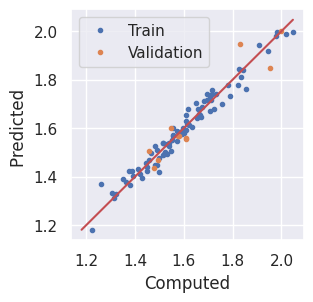

Epoch: 431, Train MAE: 0.0324, Val MAE: 0.0586
Epoch: 432, Train MAE: 0.0358, Val MAE: 0.0587
Epoch: 433, Train MAE: 0.0311, Val MAE: 0.0591
Epoch: 434, Train MAE: 0.0349, Val MAE: 0.0597
Epoch: 435, Train MAE: 0.0368, Val MAE: 0.0600
Epoch: 436, Train MAE: 0.0345, Val MAE: 0.0598
Epoch: 437, Train MAE: 0.0304, Val MAE: 0.0600
Epoch: 438, Train MAE: 0.0335, Val MAE: 0.0602
Epoch: 439, Train MAE: 0.0358, Val MAE: 0.0599
Epoch: 440, Train MAE: 0.0334, Val MAE: 0.0596


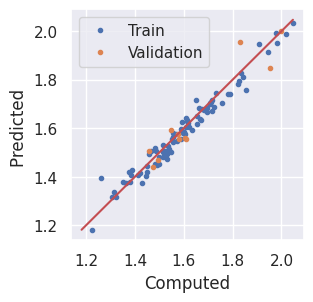

Epoch: 441, Train MAE: 0.0334, Val MAE: 0.0591
Epoch: 442, Train MAE: 0.0335, Val MAE: 0.0590
Epoch: 443, Train MAE: 0.0333, Val MAE: 0.0596
Epoch: 444, Train MAE: 0.0340, Val MAE: 0.0591
Epoch: 445, Train MAE: 0.0348, Val MAE: 0.0578
Epoch: 446, Train MAE: 0.0337, Val MAE: 0.0571
Epoch: 447, Train MAE: 0.0343, Val MAE: 0.0572
Epoch: 448, Train MAE: 0.0317, Val MAE: 0.0570
Epoch: 449, Train MAE: 0.0356, Val MAE: 0.0569
Epoch: 450, Train MAE: 0.0317, Val MAE: 0.0573


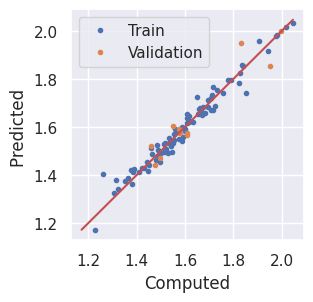

Epoch: 451, Train MAE: 0.0326, Val MAE: 0.0577
Epoch: 452, Train MAE: 0.0352, Val MAE: 0.0578
Epoch: 453, Train MAE: 0.0363, Val MAE: 0.0574
Epoch: 454, Train MAE: 0.0331, Val MAE: 0.0573
Epoch: 455, Train MAE: 0.0337, Val MAE: 0.0574
Epoch: 456, Train MAE: 0.0353, Val MAE: 0.0577
Epoch: 457, Train MAE: 0.0341, Val MAE: 0.0588
Epoch: 458, Train MAE: 0.0323, Val MAE: 0.0600
Epoch: 459, Train MAE: 0.0331, Val MAE: 0.0595
Epoch: 460, Train MAE: 0.0345, Val MAE: 0.0591


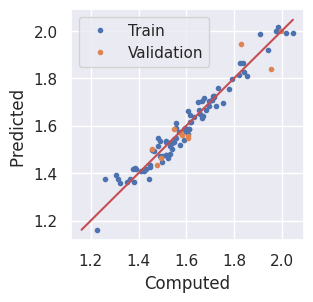

Epoch: 461, Train MAE: 0.0362, Val MAE: 0.0589
Epoch: 462, Train MAE: 0.0349, Val MAE: 0.0587
Epoch: 463, Train MAE: 0.0357, Val MAE: 0.0585
Epoch: 464, Train MAE: 0.0345, Val MAE: 0.0588
Epoch: 465, Train MAE: 0.0300, Val MAE: 0.0585
Epoch: 466, Train MAE: 0.0303, Val MAE: 0.0579
Epoch: 467, Train MAE: 0.0306, Val MAE: 0.0571
Epoch: 468, Train MAE: 0.0318, Val MAE: 0.0569
Epoch: 469, Train MAE: 0.0365, Val MAE: 0.0567
Epoch: 470, Train MAE: 0.0356, Val MAE: 0.0567


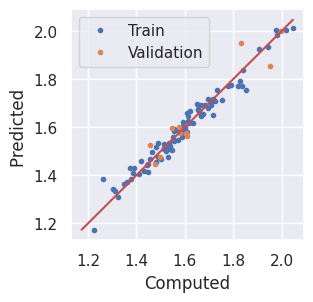

Epoch: 471, Train MAE: 0.0315, Val MAE: 0.0577
Epoch: 472, Train MAE: 0.0343, Val MAE: 0.0580
Epoch: 473, Train MAE: 0.0325, Val MAE: 0.0567
Epoch: 474, Train MAE: 0.0358, Val MAE: 0.0558
Epoch: 475, Train MAE: 0.0346, Val MAE: 0.0560
Epoch: 476, Train MAE: 0.0344, Val MAE: 0.0558
Epoch: 477, Train MAE: 0.0335, Val MAE: 0.0558
Epoch: 478, Train MAE: 0.0367, Val MAE: 0.0571
Epoch: 479, Train MAE: 0.0323, Val MAE: 0.0575
Epoch: 480, Train MAE: 0.0316, Val MAE: 0.0568


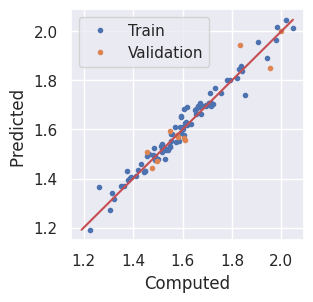

Epoch: 481, Train MAE: 0.0319, Val MAE: 0.0561
Epoch: 482, Train MAE: 0.0312, Val MAE: 0.0570
Epoch: 483, Train MAE: 0.0337, Val MAE: 0.0573
Epoch: 484, Train MAE: 0.0347, Val MAE: 0.0567
Epoch: 485, Train MAE: 0.0334, Val MAE: 0.0573
Epoch: 486, Train MAE: 0.0343, Val MAE: 0.0588
Epoch: 487, Train MAE: 0.0314, Val MAE: 0.0579
Epoch: 488, Train MAE: 0.0318, Val MAE: 0.0565
Epoch: 489, Train MAE: 0.0300, Val MAE: 0.0563
Epoch: 490, Train MAE: 0.0329, Val MAE: 0.0563


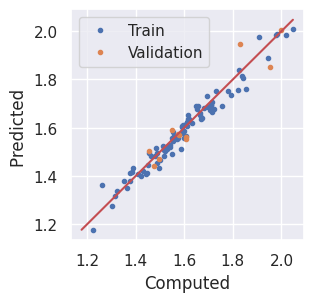

Epoch: 491, Train MAE: 0.0335, Val MAE: 0.0559
Epoch: 492, Train MAE: 0.0324, Val MAE: 0.0564
Epoch: 493, Train MAE: 0.0339, Val MAE: 0.0570
Epoch: 494, Train MAE: 0.0335, Val MAE: 0.0558
Epoch: 495, Train MAE: 0.0333, Val MAE: 0.0550
Epoch: 496, Train MAE: 0.0314, Val MAE: 0.0548
Epoch: 497, Train MAE: 0.0306, Val MAE: 0.0546
Epoch: 498, Train MAE: 0.0345, Val MAE: 0.0546
Epoch: 499, Train MAE: 0.0315, Val MAE: 0.0543
Epoch: 500, Train MAE: 0.0338, Val MAE: 0.0541


In [9]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

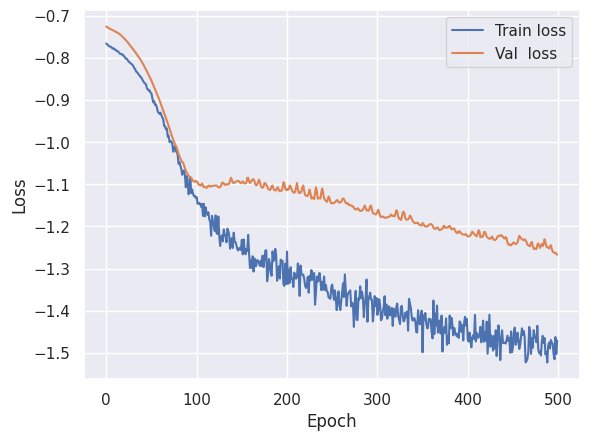

In [10]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [11]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model'], mode='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 512)
    (conv2): GraphConv(512, 512)
    (linconv1): Linear(in_features=512, out_features=64, bias=True)
    (linconv2): Linear(in_features=64, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

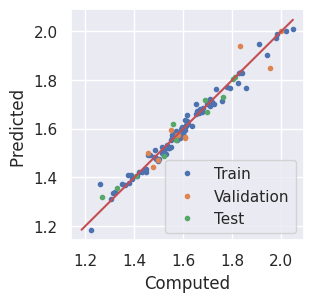

Train MAE: 0.0252, Val MAE: 0.0541, Test MAE: 0.0319


In [12]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   = clm.test(model, criterion, val_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  = clm.test(model, criterion, test_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [13]:
# Define reference dataset
# This is not necessarily just the full dataset, but it can include any
# additional validation not used as train, test or validation
dataset = [data for dataset in [train_dataset_std, val_dataset_std, test_dataset_std] for data in dataset]
for data in dataset:
    data.label = f'{data.label} {data.y[0]}'

# Save reference dataset
torch.save(dataset, files_names['r_dataset_std'])

# Generate data loader
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Standardize for better interpolation
uncert_mean  = uncertainties.mean()
uncert_std   = uncertainties.std()
uncert_scale = 1

uncertainties_std = (uncertainties - uncert_mean) * uncert_scale / uncert_std

# Check all labels are unique, otherwise you should rename them
labels = [data.label for data in dataset]
if len(labels) == len(set(labels)):
    print('All labels are unique')
else:
    print('Error: some labels are duplicated')

# Generate dictionary with uncertainty data
uncertainty_values = {}
for idx in range(len(dataset)):
    uncertainty_values.update(
        {dataset[idx].label: float(uncertainties_std[idx])}
    )
uncertainty_data = {
    'uncertainty_values': uncertainty_values,
    'uncert_mean':        uncert_mean,
    'uncert_std':         uncert_std,
    'uncert_scale':       uncert_scale
}

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncertainty_data'])

All labels are unique
